# Clustering-based Image Segmentation 
### Course: Machine Learning (INF267)
### Author: Nampouri Chryssoula - Maria (t8150096)

# Project Description

The aim of the project is the implementation of Expectation - Maximization algorithm from scratch for the segmentation of a colour image in Python.

In [1]:
import random
import numpy as np
from PIL import Image as img
from numpy import linalg as LA
from matplotlib import pyplot as plt
%matplotlib inline

# Training Image

The size of the image is $550 \times 690 \times 3$ and it is loaded as a $N \times D$ array, where each row $n_{i}$ refers to each pixel of the image and each column $d_{j}$ contains the RGB values of the specific pixel.

In total we have 379,500 RGB pixels. 

In [45]:
im = img.open("../images/coco1.jpg", "r")
image = list(im.getdata())
image = np.asarray(image)
n, d = image.shape

## View Image

<img src="../images/im.jpg">

# Normalize the data set 
<br>
Pixels' values are integers that range from 0 (black) to 255 (white). So, we divide each feature by the maximum value, in order to normalize our data in the range [0, 1]. In that way we avoid overflows and we are able to handle all the variables in the same scale.

In [46]:
# Normalize the pixels' values
image = image.astype(float)/255

# Description of EM Algorithm
The logic behind the above algorithm is that data are generated by a statistical process. More specifically we assume that data are described by a mixture of distributions, each of them corresponds to a cluster and the parameters of each distribution ($\pi_{k}, \mu_{k}, \Sigma_{k}$) describes the correspoding cluster. So, the aim is to find the parameters of the distributions/clusters that best fit the data (pixels) and assign each pixel to its nearest one, getting its values. 

<img src="../images/EM_algorithm.jpg">

In our case, we assume that our statistical model will be described by a <b> multivariate mixture of Gaussians</b>. Our data (pixels) are 3-dimensional vectors, each of those corresponds to an RGB value. Therefore, we expect each cluster to be described by a 3-dimensional mean value and a 3-dimensional covariance, one for each channel. So, the equation of the multivariate normal distribution for a specific cluster $k$ is defined as:

$$ 
P(x|k) =  \mathcal{N} (x|\mu_{k}, \Sigma_{k}) = \frac{1}{(2 \pi)^{\frac{D}{2}}|\Sigma_k|^{\frac{1}{2}}}\
e^{-\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1}(x-\mu_k)} \hspace{2cm} (1)
$$  



Another hypothesis we make, is that the pixels' values (RGB) are independent, which means an isotropic covariance matrix, i.e. a matrix with all values equal to zero, except from those of the diagonal that are equal. In this case the representation of the covariance matrix is: 
 <br>
 

$$ \Sigma_k \hspace{3mm}=\hspace{3mm} \begin{bmatrix} \sigma_k^2 & 0 & 0 \\ 0 & \sigma_k^2 & 0 \\ 0 & 0 & \sigma_k^2 \end{bmatrix} \hspace{3mm} = \hspace{4mm}\sigma_k^2 \hspace{2mm} \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $$


<br>

$$  \hspace{8cm}\Longrightarrow \Sigma_k = \sigma_k^2 I, \hspace{6cm}(2)$$
<br>
<br>where $I$ is the identity matrix and $\sigma^2$ is the variance of the channels.   <br>




<br>So, with the use of equation (2), the equation of the normal distribution $(1)$ is simplified as:
<br>

$$
P(x|k) =  \mathcal{N} (x|\mu_{k}, \Sigma_{k}) = \frac{1}{(2 \pi)^{\frac{D}{2}}|\Sigma_k|^{\frac{1}{2}}}\
e^{-\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1}(x-\mu_k)} \hspace{2cm}	\iff
$$
<br>
$$
P(x|k) =  \mathcal{N} (x|\mu_{k}, \sigma_{k}^2) = \frac{1}{(2 \pi)^{\frac{D}{2}}|\sigma_k^2 I|^{ \frac{1}{2}}}\
e^{-\frac{1}{2} (x-\mu_k)^T {\big({(\sigma_k I)}^2\big)}^{-1}(x-\mu_k)}\hspace{2cm} \iff
$$
<br>
$$
P(x|k) =  \mathcal{N} (x|\mu_{k}, \sigma_{k}^2) = \frac{1}{(2 \pi)^{\frac{D}{2}} {({\sigma_k^{2D}} |I|)} ^{\frac{1}{2}}}\
e^{-\frac{1}{2\sigma_k^2} (x-\mu_k)^T (x-\mu_k)}\hspace{2cm}\iff
$$
<br>
$$
P(x|k) =  \mathcal{N} (x|\mu_{k}, \sigma_{k}^2) = \frac{1}{(2 \pi)^{\frac{D}{2}}{(\sigma_k^2)}^{\frac{D}{2}}}\
e^{-\frac{1}{2\sigma_k^2} {\lVert{x-\mu_k}\rVert}^2}\hspace{2cm}\iff
$$
<br>
$$
P(x|k) =  \mathcal{N} (x|\mu_{k}, \sigma_{k}^2) = \frac{1}{(2 \pi \sigma_k^2)^{\frac{D}{2}}}\
e^{-\frac{1}{2\sigma_k^2} \big((x_r - \mu_{kr})^2 + (x_g - \mu_{kg})^2 + (x_b - \mu_{kb})^2 \big)}\hspace{2cm}\iff
$$
<br>

$$
P(x|k) =  \mathcal{N} (x|\mu_{k}, \sigma_{k}^2) = \frac{1}{\sqrt{2 \pi \sigma_k^2}^D}\
e^{-\frac{1}{2\sigma_k^2} (x_r - \mu_{kr})^2 }\hspace{5mm} e^{-\frac{1}{2\sigma_k^2} (x_g - \mu_{kg})^2 }\hspace{5mm} e^{-\frac{1}{2\sigma_k^2} (x_b - \mu_{kb})^2 }\hspace{2cm}\iff
$$
<br>
$$
P(x|k) =  \mathcal{N} (x|\mu_{k}, \sigma_{k}^2) = \prod_{d=1}^{D} \frac{1}{\sqrt{2 \pi \sigma_k^2}}\
e^{-\frac{1}{2\sigma_k^2} (x_d - \mu_{kd})^2 }
$$

# Initialize Parameters
The first step of the Expectation - Maximization algorithm is to initialize each cluster with a mean value, a variance and a priori probability that it occurs. The result is a $K \times D $ mean value matrix, where $K$ is the number of clusters and $D$ is the number of the correspoding mean RGB values and a $ K \times 1$ variance matrix, while the variance of each cluster is the same for all the channels.
As for the priori probabilities of the clusters, we initialize their values uniformly in a $1 \times K$ matrix.

In [5]:
def init_parameters(image, k):
    
    """ Initialize all the necessary variables for the EM algorithm.
    
    :param image: The N x D matrix with the pixels' values of the initial image
    :param k: The number of categories/clusters in which we want to segment the image
    :return: 
        mu: The K x D matrix with the initial centroids/means of each cluster
        sigma: The K x 1 matrix with the initial variance of each cluster
        pi: The 1 x K matrix with the initial priori probability of each cluster
    
    """
    
    # choose the starting centroids/means randomly
    ## as pixels of the image
    mu = random.sample(list(image), k)
    mu = np.asarray(mu)
    
    # initialize the variance matrices for each gaussian
    sigma = np.random.rand(k,1)
    
    # initialize the priori probabilities for each gaussian
    pi = [1/k] * k
    pi = np.asarray(pi)
    
    return mu, sigma, pi

# Probability Density Function
The Probability Density Function computes the probability that a random variable $x$ has been generated from a normal distribution with mean $\mu_{k}$ and variance $\sigma_{k}^2$. In this case, the function below computes the probability density of a specific cluster $k$ and only for one channel $d$ (RGB value) of every pixel.
The goal is to check how close is the red value of a pixel to the mean red value of a distribution, its green value to the mean green and its blue value to the mean blue.

Therefore, the equation is defined as:

$$
{p(x_d|k)}= \mathcal{N} (x_d|\mu_{kd}, \sigma_{k}^2) = \frac{1}{\sqrt{2\pi{\sigma_{k}}^2}}e^{-\frac{1}{2{\sigma_{k}}^2}{(x_d-\mu_{kd})}^2}$$


In [6]:
def density_function (image_j, mu_j, sigma_j):
    
    """ Compute probability density for each pixel's value and each category.
    
    :param image_j: The N x 1 matrix containing the pixels' values of a specific rgb channel
    :param mu_j: The mean value of one category/distribution and the correspoding rgb channel
    :param sigma_j: The variance of one category/distribution
    :return prob: The N x 1 matrix with the probabilities that each value of image_j has been generated 
        from a normal distribution with mean mu_j and variance sigma_j.
        
    """
    
    prob = ( 1 / np.sqrt( 2 * np.pi * sigma_j  ) ) * \
            np.exp( - (image_j - mu_j) ** 2 /( 2 * sigma_j ) )

    return prob

# Expectation Step

Through Expectation step, the algorithm finds the posteriori probabilities that each pixel belongs to each cluster.<b> As for the probability density function, it should be noted that it first calculates individually the probabilities of every rgb channel and then computes the product of them for every pixel, while rgb values are independent.</b> In that way, it gets the total probabilities for every pixel and cluster (which consists of rgb channels) and is able to calculate the posteriori probabilities. 

The total equation of the Expectation procedure is:

$$
p(k|x) =\frac{ p(x|k) p(k)}{p(x)} \\
$$
$\hspace{12cm} \Downarrow$

$$
\gamma{(z_k)} = \frac{\pi_{k} \prod_{d=1}^{D} \mathcal{N} (x_{d}|\mu_{kd}, \sigma_{k}^2)} {\sum_{k=1}^{K} \pi_k \prod_{d=1}^{D} \mathcal{N} (x_{d}|\mu_{kd}, \sigma_{k}^2)},  \hspace{5mm} k=1,...,K
$$





In [7]:
def expectation(image, mu, sigma, pi): 
    
    """ Implementation of Expectation step of the algorithm.
    
    :param image: The N x D matrix with the pixels' values of the initial image
    :param mu: The K x D matrix with the current centroids/means of each cluster
    :param sigma: The K x 1 matrix with the current variance of each cluster
    :param pi: The 1 x K matrix with the current priori probability of each cluster
    :return:
        prob: The N x K matrix with the product of the likelihood and the priori probability 
            of each pixel and cluster
        r: The N x K matrix with the posteriori probabilities
        
    """
    
    r = np.zeros((n,k))
    prob = np.zeros((n,k))
    
    for i in range(k):
        red = np.zeros((n,1))
        green = np.zeros((n,1))
        blue = np.zeros((n,1))
        
        # compute for each rgb channel of the image the density function for the current category k
        red = density_function(image[:,0], mu[i,0], sigma[i])
        green = density_function(image[:,1], mu[i,1], sigma[i])
        blue = density_function(image[:,2], mu[i,2], sigma[i])
        
        # compute the total probability that each pixel belongs to the current category k
        density = red * green * blue
        prob[:,i] = pi[i] * density  
    
    # compute the posteriori probabilities
    for i in range(len(prob)):
        total = np.sum(prob[i])
        r[i] = prob[i]/total

    return prob, r

# Maximization Step
After computing the cluster membership probabilities for all the pixels, we compute new estimates for $\mu_{k}$, $\sigma_k$ and $\pi_k$, in order to best fit them. This is the maximization step. Here, the new estimate for the mean of a distribution is just a weighted average of the points, where the weights are the probabilities that the points belong to that distribution. These probabilities has occured through the expectation step. 

The following procedure happens for every cluster ($\times K$) and every rgb channel ($ \times D$):

$$
\mu_{kd}^{new} = \frac{\sum_{n=1}^{N} \gamma{(z_{nk})} x_{nd}}{\sum_{n=1}^{N} \gamma{(z_{nk})}},  \hspace{5mm} k=1,...,K \hspace{3mm} \& \hspace{3mm} d=1,...,D$$

As for the variance, the new estimations are:

$$ 
\Sigma_k^{new} = \frac{\sum_{n=1}^{N}\gamma{(z_{nk})} (x_{n} - m_{k}^{new})(x_{n} - m_{k}^{new})^T}{D\sum_{n=1}^{N} \gamma{(z_{nk})}},  \hspace{5mm} k=1,...,K \hspace{3mm} \Longrightarrow 
$$
<br>

$$
\Sigma_k^{new} = \frac{\sum_{n=1}^{N}\gamma{(z_{nk})} \hspace{2mm} {\lVert{ x_{n} - \mu_{k}^{new} }\rVert}^2 }{D\sum_{n=1}^{N} \gamma{(z_{nk})}} ,  \hspace{5mm} k=1,...,K \hspace{3mm} \Longrightarrow 
$$

<br>

$$
\Sigma_k^{new} = \frac{\sum_{n=1}^{N}\gamma{(z_{nk})} \left(( x_{nr} - \mu_{kr}^{new} )^2 \hspace{1mm} + (x_{ng} - \mu_{kg}^{new})^2 +\hspace{1mm} (x_{nb} - \mu_{kb}^{new})^2 \right)}
{D\sum_{n=1}^{N} \gamma{(z_{nk})}},  \hspace{5mm} k=1,...,K \hspace{3mm} \Longrightarrow 
$$

<br>

$$
\Sigma_k^{new} = \frac{\sum_{n=1}^{N} \sum_{d=1}^{D}  \gamma{(z_{nk})} ( x_{nd} - \mu_{kd}^{new} )^2}
{D\sum_{n=1}^{N} \gamma{(z_{nk})}},  \hspace{5mm} k=1,...,K \hspace{3mm}\Longrightarrow 
$$

<br>

Lastly, the new estimations for priori probabilities are defined as:


$$
\pi_k^{new} = \frac{\sum_{n=1}^{N} \gamma{(z_{nk})}}{N},  \hspace{5mm} k=1,...,K  $$

In [8]:
def maximization(image, r):
    
    """ Update all the necessary variables.
    
    :param image: The N x D matrix with the pixels' values of the initial image
    :param r: The N x K matrix with the posteriori probabilities
    :return:
        mu: The K x D matrix with the updated centroids/means of each category
        sigma: The K x 1 matrix with the updated variance of each category
        pi: The 1 x K matrix with the updated priori probabilities of each category
        
    """
    
    # update mean values of each category/cluster
    temp = np.dot(r.T, image)
    total = np.sum(r, axis = 0, keepdims = True)
    mu = temp / total.T

    # update variance of each category/cluster
    for i in range(k):
        temp = np.power( (image - mu[i]), 2 )
        temp = r[:,i] * np.sum(temp, axis = 1)
        temp = np.sum(temp, axis = 0)

        sigma[i] = temp / (d * total[0,i])

    # update priori probabilities of each category/cluster
    pi = total[0] / n

    return mu, sigma, pi

# Reconstruction Error
The function below computes the mean error of the reconstructed image, as the distance between its pixels' values and the values of the pixels of the initial image. For the distance calculation, $L2$ Norm is used.

So, the reconstruction error is defined as:

$$
\textit{error} = \frac{1}{N} \sum_{n=1}^{N} {\lVert{x_{true,n} - x_{r,n}}\rVert}^2 $$

In [9]:
def error_function(image, new_image):
    
    """ Computes the reconstruction error of the new_image.
    
    :param image: The N x D matrix with the pixels' values of the initial image
    :param new_image: The N x D matrix with the pixels' values of the reconstructed image
    :return error: The error (distance) between the pixels' values of the two images 
    
    """
    
    error = 1/n * sum(LA.norm(image - new_image, axis = 1)**2)
    
    return error

# Convergence Function
The function below implements the terminal criterion. As a metric we use the <b>log-likelihood</b>, that we want to maximize. As far as its value increases, the algorithm continues with new calculations, otherwise it terminates. 

In [10]:
def convergence(old_likelihood, new_likelihood, tol):
    
    """ Check convergence of the algorithm.
    
    :param old_likelihood: The log-likelihood of the previous iteration
    :param new_likelihood: The log-likelihood of the current iteration
    :param tol: The tolerance value 
    :return:
        old_likelihood: The updated log-likelihood for next iterations
        match: The boolean variable describing the convergence
        
    """
    
    if np.abs(new_likelihood - old_likelihood) < tol:
        match = True
    else:
        old_likelihood = new_likelihood
        match = False
        
    return old_likelihood, match

# Expectation - Maximization Algorithm
The function below is called for each predefined number of clusters. Each time it runs the expectation and maximization step, until the convergence to the best values that describe the compressed image.

In [11]:
def EM_algorithm(image, mu, sigma, pi, error):
    
    """ The implementation of the Expectation - Maximization algorithm.
    
    :param image: The N x D matrix with the pixels' values of the initial image
    :param mu: The K x D matrix with the initial centroids/means of each cluster
    :param sigma: The K x 1 matrix with the initial variance of each cluster
    :param pi: The 1 x K matrix with the initial priori probability of each cluster
    :param error: The matrix with the reconstruction error of the images 
        for each chosen number of categories/clusters
    :return:
        new_image: The N x D matrix with the pixels' values of the reconstructed image
        error: The recostruction error of the new_image
        mu: The K x D matrix with the final centroids/means of each category/cluster
        sigma: The K x 1 matrix with the final variance of each category/cluster
        pi: The 1 x K matrix with the final priori probabilities of each category/cluster
    
    """
    
    new_image = np.zeros((n,k))
    old_likelihood = 0
    match = False
    tol = 1e-2
    
    # while the terminal criterion is not satisfied; continue the iterations
    while not match:
        # run the expectation step
        prob, r = expectation(image, mu, sigma, pi)
        # run the maximization step
        mu, sigma, pi = maximization(image, r)
        
        # compute log-likelihood 
        total = np.sum(prob, axis = 1)
        new_likelihood = np.sum(np.log(total))
        # check for convergence
        old_likelihood, match = convergence(old_likelihood, new_likelihood, tol)
        
    # update the pixels' values with the mean values of the most probable category they belong to
    new_image = mu[np.argmax(r, axis = 1)]
    # compute the error (distance) between the initial image and the new one
    error.append(error_function(image, new_image))
    
    return new_image, error, mu, sigma, pi

# Plot Reconstructed Image

In [43]:
def plot_image(new_image, k):
     
    """ Plot the reconstructed image.
    
    :param new_image: The N x D matrix with the pixels' values of the reconstructed image
    :param k: The number of categories/clusters
    
    """
    
    imag = np.reshape(new_image, (im.size[1], im.size[0], 3))
    plt.imsave('../output/' + str(k) + '_Categories.jpg', imag)
    
    fig = plt.figure()
    a = fig.add_subplot(1, 2, 1)
    imag = np.reshape(image, (im.size[1], im.size[0], 3))
    imgplot = plt.imshow(imag)
    a.set_title('Original Image')

    a = fig.add_subplot(1, 2, 2)
    imag = np.reshape(new_image, (im.size[1], im.size[0], 3))
    imgplot = plt.imshow(imag)
    a.set_title('K= ' +str(k) )
    
    plt.show()
    plt.clf()

# Plot Error

In [13]:
def plot_error(error):
    
    """ Plots the error line for different number of clusters.
  
    :param error: The 7 x 1 matrix with the final error of each predefined number of clusters
    
    """
    
    x = range( 1, len(error)+1 )
    y = error
    plt.plot( x, y )
    plt.ylabel( 'error' )
    plt.xlabel( 'clusters' )
    plt.title( "Error by increasing the number of clusters: " )
    plt.xticks( x )
    plt.show()

# Run Expectation - Maximization Algorithm
The procedure below implements the Expectation - Maximization algorithm for different number of distributions/clusters ($k$). Each time, it generates a new compressed image based on $k$ different colours and calculates the reconstruction error from the initial one.

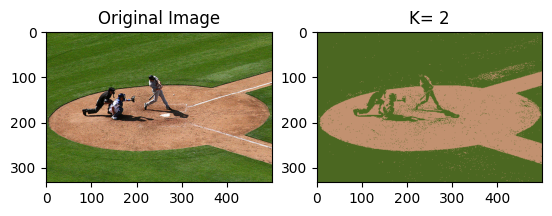

The reconstruction error for 2 clusters is: 0.02467353032807429


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [47]:
# number of categories/clusters
k = 2
error = []
# reconstruct the initial image for different number of categories/clusters (e.g. 2,4,8,16,32,64,128)
while k <= 128:
    # initialize parameters
    mu, sigma, pi = (init_parameters(image, k))
    # run Expectation - Maximization algorithm
    new_image, error, mu, sigma, pi = EM_algorithm(image, mu, sigma, pi, error)
    # plot reconstructed image
    plot_image(new_image, k)
    e = error[int(np.log2(k)-1)]
    print("The reconstruction error for " + str(k) + " clusters is: " + str(e))
    k *= 2
    
# plot the error function
plot_error(error)

# Results

 $$ \begin{matrix}
                    \\
\textbf{Clusters/Categories} & \textbf{Iterations} & \textbf{Reconstruction Error} \\    \hline
2 & 23 & 0.04882768790822941 \\    \hline
4 & 107 & 0.016801744183826944\\    \hline
8 & 154 & 0.007940573068342224\\    \hline
16 & 452 & 0.0038803141642229227\\    \hline
32 & 548 & 0.0019798988582252985\\    \hline
64 & 1693 & 0.0009322353167936464\\    \hline
128 & 2013 & 0.000520232704578564\\    \hline
    \end{matrix} 
    $$